## Predict Future Sales

In this notebook we work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 
We predict total sales for every product and store in the next month.

In [2]:

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info



sys.version_info(major=3, minor=7, micro=9, releaselevel='final', serial=0)

#### Read data

In [4]:
path=""
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('item_categories.csv')
train = pd.read_csv('sales_train_v2.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('test.csv').set_index('ID')

#### Check outliers

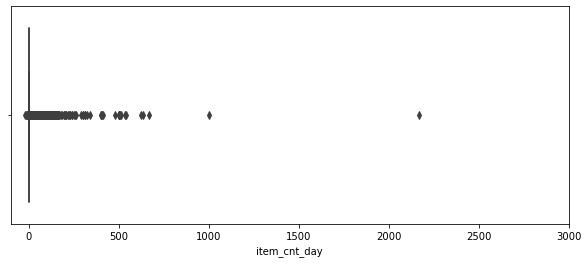

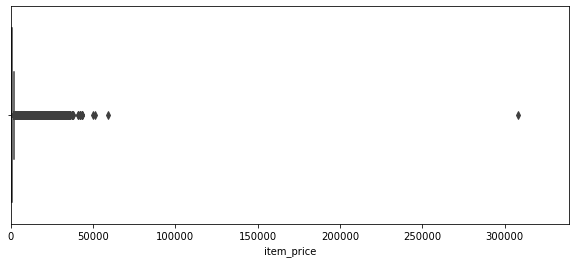

In [5]:

plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)



Remove outliers

In [6]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

Fix duplicates shops in train and test set

In [7]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [8]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

In [10]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

26.58901858329773

In [11]:

train['revenue'] = train['item_price'] *  train['item_cnt_day']


In [12]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts



6.602919578552246

In [13]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)


In [14]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.2176063060760498

####  Shops/Items/Cats features

In [15]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

5.4618613719940186

In [16]:
matrix.head(5)

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0,40,11,4
1,0,2,27,1.0,0,19,5,10
2,0,2,28,0.0,0,30,8,55
3,0,2,29,0.0,0,23,5,16
4,0,2,32,0.0,0,40,11,4


In [17]:


def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df



In [18]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

49.0884051322937

#### Mean encoded features

In [19]:


ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts



13.292909860610962

In [20]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


46.54400825500488

In [21]:


ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts



43.617056369781494

In [22]:


ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts



14.438154220581055

In [23]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

14.795313596725464

In [24]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

15.5177743434906

In [25]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

14.667360067367554

In [26]:


ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts



14.294906854629517

In [27]:


ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts



24.071866512298584

In [28]:


ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts



14.478575706481934

In [29]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

14.695151329040527

#### Trend features

In [30]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts


614.4167339801788

In [31]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts


17.08329486846924

In [32]:
matrix['month'] = matrix['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)


ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

2373.0090715885162

In [33]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts


1579.7540814876556

In [34]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts


1.9643371105194092

In [35]:
#Final prep

ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta

In [36]:
matrix.to_pickle('data.pkl')

del cache
gc.collect();

In [39]:
shops = pd.read_csv('shops.csv')

In [42]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


#### Add population feature

In [55]:
shops.loc[shops.city == 'Москва', 'population'] = 12678079
shops.loc[shops.city == 'Якутск', "population"] = 322987
shops.loc[shops.city == 'Воронеж', "population"] = 1058261
shops.loc[shops.city == 'Тюмень', "population"] = 807400
shops.loc[shops.city == 'РостовНаДону', "population"] = 1137904
shops.loc[shops.city == 'Н.Новгород', "population"] = 1252236
shops.loc[shops.city == 'Жуковский', "population"] = 107560
shops.loc[shops.city == 'СПб', "population"] = 5398064
shops.loc[shops.city == 'Уфа', "population"] = 1128787
shops.loc[shops.city == 'Новосибирск', "population"] = 1625631
shops.loc[shops.city == 'Красноярск', "population"] =  1093771
shops.loc[shops.city == 'Омск', "population"] = 1154507
shops.loc[shops.city == 'Ярославль',"population"] = 608353
shops.loc[shops.city == 'Химки', "population"] = 259550
shops.loc[shops.city == 'Вологда', "population"] = 310302
shops.loc[shops.city == 'Выездная', "population"] = None
shops.loc[shops.city == 'Цифровой', "population"] = None
shops.loc[shops.city == 'Мытищи', "population"] = 235504
shops.loc[shops.city == 'Курск', "population"] = 452976
shops.loc[shops.city == 'Коломна', "population"] = 140129
shops.loc[shops.city == 'Адыгея', "population"] = 932629 
shops.loc[shops.city == 'Томск', "population"] = 576624
shops.loc[shops.city == 'Волжский', "population"] = 1400000
shops.loc[shops.city == 'Чехов', "population"] = 72231
shops.loc[shops.city == 'Сургут', "population"] = 380632
shops.loc[shops.city == 'Интернет-магазин', "population"] = None
shops.loc[shops.city == 'СергиевПосад', "population"] = 100335
shops.loc[shops.city == 'Балашиха', "population"] = 507366
shops.loc[shops.city == 'Самара', "population"] = 1156659
shops.loc[shops.city == 'Калуга', "population"] = 332039
shops.loc[shops.city == 'Казань', "population"] = 1257391

In [56]:
shops["population"]=shops["population"].fillna(round(shops["population"].median()))

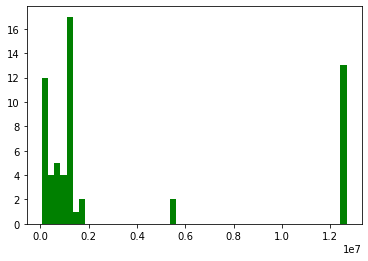

In [63]:

plt.hist(shops["population"],50, facecolor='g')
plt.show()


In [65]:
from sklearn.preprocessing import MinMaxScaler

shops['population_MinMax'] = MinMaxScaler().fit_transform(shops[['population']])
shops.head()

,shop_name,shop_id,city,population,population_std,population_MinMax
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,322987.0,-0.655973,0.019892
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,322987.0,-0.655973,0.019892
2,"Адыгея ТЦ ""Мега""",2,Адыгея,932629.0,-0.531409,0.068254
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,507366.0,-0.618300,0.034519
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,1400000.0,-0.435914,0.105330


#### Add shop_group feature

In [102]:
 matrix_pt = pd.pivot_table(matrix[matrix['item_cnt_month'] != 0], 
                           values='item_cnt_month', index=['shop_id'], 
                           columns = ['date_block_num','item_category_id'], #item_category_id
                           aggfunc='count', fill_value = 0)

In [103]:
matrix_pt.head()

date_block_num    12                                                        \
item_category_id  2  3  4  5  6  9  11 12 14 15 17  19  20  21  22  23  25   
shop_id                                                                      
2                 12  6  0  0  6  0  3  0  0  2  1  95   9   7   9  51   3   
3                  7  7  1  6  7  0  2  0  3  2  0  62  10  15  13  56   6   
4                 12  7  5  3  9  0  4  1  0  4  1  69   7  12   9  57  13   
5                 16  6  0  7  5  0  4  1  2  1  3  64  12  14   8  47   8   
6                 16  8  1  4  5  0  6  1  2  3  0  85  11   5  11  58  22   

date_block_num                                                               \
item_category_id  28 29   30 31 32 33 35   37  38 39   40  41  43 44 45  49   
shop_id                                                                       
2                 17  2   61  0  2  3  3   42  17  0   64   3   0  0  0   2   
3                 33  4   70  0  2  2  3   37  12  0  103   5   0  0  0   0   
4                 34  3   89  0  1  4  4   49  19  0  108   2   0  0  0   1   
5                 32  2  102  0  3  3  4   74  22  0  223  19   0  0  0   3   
6                 46  2  121  0  5  4  4  183  31  0  253  25  31  0  4  18   

date_block_num                                                               \
item_category_id 54   55  56  57  58 59 60 61  62  63  64  65 66  67 68  69   
shop_id                                                                       
2                 0    1   0   1   1  0  0  0   6  10  10   4  0   5  0   0   
3                 0   91   0   0   0  0  1  0   5   7   7   4  0   1  0   2   
4                 0  160   0   0   2  0  0  0  12  10  12   6  0  11  0   2   
5                 0  151   0   1   0  0  0  2  12  14  19   9  0  15  0   9   
6                 0  272  14  33  45  9  4  1  24  19  21  19  0  22  0  16   

date_block_num        ...  33                                                 \
item_category_id  70  ...  20 21  22  23  24 25 26 27  28 29  30 31 33 34 35   
shop_id               ...                                                      
2                  1  ...  36  2   8  38  10  7  0  0  14  2  45  0  1  0  4   
3                  8  ...  28  1   8  32  14  0  0  0  17  1  40  0  1  0  4   
4                  2  ...  25  2   3  29   8  1  0  0  12  1  46  0  1  0  3   
5                  4  ...  25  4   4  39   9  7  0  0  13  1  56  0  1  0  3   
6                 16  ...  39  0  11  25  23  0  0  0  18  2  54  0  1  0  3   

date_block_num                                                               \
item_category_id 36  37  38   40 41 42 43 44 45  47 49 54   55 56 57  58 60   
shop_id                                                                       
2                 0  41   7   65  1  4  1  0  0  12  3  0    2  1  0   0  0   
3                 0  31   3   66  4  1  0  0  0   0  3  0   34  1  1   0  0   
4                 0  25   7   84  5  3  0  0  0   9  0  0   91  1  0   0  0   
5                 0  33  15  101  4  5  1  0  0  33  0  0   89  2  1   0  1   
6                 0  83  19  167  9  9  0  0  0  39  5  0  166  8  2  48  0   

date_block_num                                                                 
item_category_id 61 62  63  64  65 67  69  70 71  72 73 74  75 76 77 78 79 83  
shop_id                                                                        
2                 3  0  18   9   6  3   7  11  0   9  2  0   3  0  0  0  1  2  
3                 0  0  13   5   7  1   4   7  1   6  0  0   4  0  0  0  1  2  
4                 7  0  11  16  17  6   1   7  1   9  1  0   7  0  0  0  1  0  
5                 5  0  23  11  20  5  10  14  1  17  0  0   2  0  0  0  1  2  
6                 9  1  18  18  25  7  15  17  1  26  2  0  11  0  0  0  1  4  

[5 rows x 1376 columns]

In [104]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=0).fit(matrix_pt)
matrix_pt['shop_group'] = kmeans.labels_.astype('int8')
matrix['shop_group'] = matrix['shop_id'].map(matrix_pt['shop_group'])

In [109]:
shops_n_groups = pd.merge(shops.set_index('shop_id'), matrix_pt['shop_group'], on=['shop_id'], how='left')

for group in shops_n_groups['shop_group'].unique():
    print(group)
    print(shops_n_groups[shops_n_groups['shop_group']==group]['shop_name'].unique())


nan
[]
2.0
['Адыгея ТЦ "Мега"' 'Балашиха ТРК "Октябрь-Киномир"'
 'Волжский ТЦ "Волга Молл"' 'Жуковский ул. Чкалова 39м²'
 'Интернет-магазин ЧС' 'Казань ТЦ "ПаркХаус" II' 'Коломна ТЦ "Рио"'
 'Красноярск ТЦ "Взлетка Плаза"' 'Красноярск ТЦ "Июнь"'
 'Москва Магазин С21' 'Новосибирск ТЦ "Мега"' 'Омск ТЦ "Мега"'
 'РостовНаДону ТРК "Мегацентр Горизонт"' 'РостовНаДону ТЦ "Мега"'
 'СПб ТК "Сенная"' 'Самара ТЦ "ПаркХаус"' 'Томск ТРЦ "Изумрудный Город"'
 'Тюмень ТРЦ "Кристалл"' 'Ярославль ТЦ "Альтаир"']
0.0
['Вологда ТРЦ "Мармелад"' 'Воронеж (Плехановская, 13)'
 'Воронеж ТРЦ "Максимир"' 'Калуга ТРЦ "XXI век"' 'Курск ТЦ "Пушкинский"'
 'Москва МТРЦ "Афи Молл"' 'Москва ТК "Буденовский" (пав.К7)'
 'Москва ТЦ "Ареал" (Беляево)' 'Москва ТЦ "МЕГА Белая Дача II"'
 'Москва ТЦ "Новый век" (Новокосино)' 'Москва ТЦ "Перловский"'
 'Н.Новгород ТРЦ "Фантастика"' 'Самара ТЦ "Мелодия"'
 'СергиевПосад ТЦ "7Я"' 'Сургут ТРЦ "Сити Молл"' 'Тюмень ТЦ "Гудвин"'
 'Тюмень ТЦ "Зеленый Берег"' 'Уфа ТК "Центральный"' 'Уфа ТЦ

In [115]:
shops = shops[['shop_id', 'population_MinMax']]
matrix=pd.merge(matrix, shops, on=['shop_id'], how='left')

matrix['population_MinMax'] = matrix['population_MinMax'].astype(np.float32)
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta

####  Add  date_item_group_avg_item_cnt_lag_1 feature

In [117]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'shop_group']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_group_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_group'], how='left')
matrix['date_item_group_avg_item_cnt'] = matrix['date_item_group_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_group_avg_item_cnt')
matrix.drop(['date_item_group_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

43.48305296897888

In [118]:
matrix.to_pickle('data2.pkl')

In [127]:
data = matrix[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
    
    #'shop_group', 
    'population_MinMax',
    'date_item_group_avg_item_cnt_lag_1'
]]

In [128]:

X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [129]:
del data
gc.collect();

In [130]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[0]	validation_0-rmse:1.04839	validation_1-rmse:1.03670
[1]	validation_0-rmse:0.97037	validation_1-rmse:0.97623
[2]	validation_0-rmse:0.91356	validation_1-rmse:0.94273
[3]	validation_0-rmse:0.88079	validation_1-rmse:0.92344
[4]	validation_0-rmse:0.86274	validation_1-rmse:0.91430
[5]	validation_0-rmse:0.85200	validation_1-rmse:0.90943
[6]	validation_0-rmse:0.84540	validation_1-rmse:0.90689
[7]	validation_0-rmse:0.83767	validation_1-rmse:0.90805
[8]	validation_0-rmse:0.83402	validation_1-rmse:0.90679
[9]	validation_0-rmse:0.83001	validation_1-rmse:0.90731
[10]	validation_0-rmse:0.82588	validation_1-rmse:0.90730
[11]	validation_0-rmse:0.82395	validation_1-rmse:0.90911
[12]	validation_0-rmse:0.82229	validation_1-rmse:0.90749
[13]	validation_0-rmse:0.82101	validation_1-rmse:0.90708
[14]	validation_0-rmse:0.81943	validation_1-rmse:0.90827
[15]	validation_0-rmse:0.81731	validation_1-rmse:0.90889
[16]	validation_0-rmse:0.81643	validation_1-rmse:0.90906
[17]	validation_0-rmse:0.81517	validation

321.7654230594635

In [131]:

Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))


In [132]:
submission.head()

,ID,item_cnt_month
0,0,0.430676
1,1,0.566771
2,2,0.832242
3,3,0.494373
4,4,3.505560


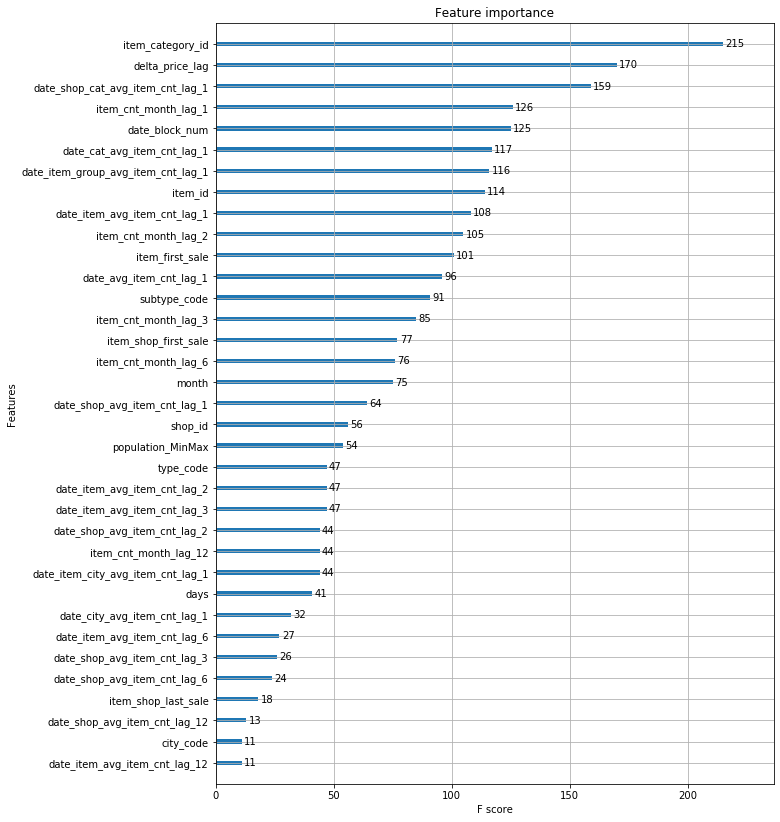

In [133]:
plot_features(model, (10,14))